## This notebook implements the FusFormer method on the University of Houston RGB and Hyperspectral images

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import shutil
import random
import cv2
import math
import os
from spectral import *
from tqdm import tqdm
from argparse import Namespace
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch import Tensor
import torchsummary
import torchprofile

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Defining the Gaussian PSF for synthetic data generation

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

In [4]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [5]:
# Function to visualize an HSI
def visualize_hsi(img1, img2, bands, title1, title2):
    """
    Visualize two hyperspectral images side by side using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    img2 : np.ndarray
        Second hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation (applied to both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    """
    rgb1 = get_rgb(img1, bands)
    rgb2 = get_rgb(img2, bands)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(rgb1)
    axs[0].set_title(title1)
    axs[0].axis('on')

    axs[1].imshow(rgb2)
    axs[1].set_title(title2)
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

In [6]:
# Function to visualize an HSI
def visualize_hsi_single(img1, bands, title1):
    """
    Visualize a hyperspectral image using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation
    title1 : str
        Title for the first image.
    """
    rgb1 = get_rgb(img1, bands)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.imshow(rgb1)
    ax.set_title(title1)
    ax.axis('on')

    plt.tight_layout()
    plt.show()
    
# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image, bands, title, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image : np.ndarray
        Multispectral image, shape: (rows, cols, num_bands).
    bands : tuple
        Band indices to use for RGB representation (only used if num_bands >= 3).
    title : str
        Title for the image plot.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands (x-axis for SRF).
    ikonos_bands : np.ndarray
        An array with shape (num_bands, 3) containing [center_nm, low_edge_nm, high_edge_nm]
        for each band. It is used here just to show the center wavelength in the legend.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image.shape[2]  # e.g. 1,3,4,8,16

    # 1) Choose band labels & colors depending on how many bands we have
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        # You can pick any 8 distinct colors you like:
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        # Again, pick any 16 distinct colors you like:
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")
    
    # 2) Create the figure with 2 subplots (image on the left, SRF on the right)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # 3) Plot the image
    if num_bands == 1:
        # Just display the single-band image in grayscale
        single_band_2d = ms_image[:, :, 0]  # shape (rows, cols)
        axs[0].imshow(single_band_2d, cmap="gray")
        axs[0].set_title(title + " (Single-Band/Panchromatic)")
    else:
        # We have at least 3 bands, so let's form an RGB image
        img_rgb = get_rgb(ms_image, bands)
        axs[0].imshow(img_rgb)
        axs[0].set_title(title)
    axs[0].axis('off')
    
    # 4) Plot the SRF curves in the second subplot
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]  # The 'center' column from your band_specs
        axs[1].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Spectral Response')
    axs[1].set_title('Spectral Response Functions (SRF)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Importing the University of Houston images

In [7]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Real_world_Fusion_based_HSI_Super_Resolution_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
hsi_1_file_path = os.path.join(normalized_dataset_path, 'hsi_1.mat')
hsi_2_file_path = os.path.join(normalized_dataset_path, 'hsi_2.mat')
rgb_1_file_path = os.path.join(normalized_dataset_path, 'rgb_image_1.tif')
rgb_2_file_path = os.path.join(normalized_dataset_path, 'rgb_image_2.tif')

In [8]:
def extract_aligned_patches(lr_hsi, hr_rgb, hsi_center_y, hsi_center_x,
                            hsi_patch_size=64, rgb_scale_factor=20, rgb_downsampled_size=512):
    """
    Extract a 64x64 patch from the LR HSI centered at (hsi_center_y, hsi_center_x),
    and the corresponding 1280x1280 patch from the HR RGB image centered at the
    scaled coordinates. Then downsample the RGB patch to 512x512.

    Parameters:
    -----------
    lr_hsi : np.ndarray
        Low-resolution HSI image of shape (H_lr, W_lr, C_hsi).
    hr_rgb : np.ndarray
        High-resolution RGB image of shape (H_hr, W_hr, 3).
    hsi_center_y : int
        Y-coordinate of the HSI patch center.
    hsi_center_x : int
        X-coordinate of the HSI patch center.
    hsi_patch_size : int
        Patch size for the HSI (default: 64).
    rgb_scale_factor : int
        Scaling factor between HSI and RGB resolutions (default: 20).
    rgb_downsampled_size : int
        Final size of the RGB patch after downsampling (default: 512).

    Returns:
    --------
    hsi_patch : np.ndarray
        Extracted HSI patch of shape (hsi_patch_size, hsi_patch_size, C_hsi).
    rgb_patch_downsampled : np.ndarray
        Downsampled RGB patch of shape (rgb_downsampled_size, rgb_downsampled_size, 3).
    """
    
    # --- HSI patch extraction ---
    half_hsi = hsi_patch_size // 2
    hsi_top = hsi_center_y - half_hsi
    hsi_left = hsi_center_x - half_hsi

    if (hsi_top < 0 or hsi_left < 0 or 
        hsi_top + hsi_patch_size > lr_hsi.shape[0] or 
        hsi_left + hsi_patch_size > lr_hsi.shape[1]):
        raise ValueError("HSI patch goes out of bounds.")

    hsi_patch = lr_hsi[
        hsi_top : hsi_top + hsi_patch_size,
        hsi_left : hsi_left + hsi_patch_size,
        :
    ]

    # --- RGB patch extraction ---
    rgb_patch_size = hsi_patch_size * rgb_scale_factor
    half_rgb = rgb_patch_size // 2
    rgb_center_y = hsi_center_y * rgb_scale_factor
    rgb_center_x = hsi_center_x * rgb_scale_factor
    rgb_top = rgb_center_y - half_rgb
    rgb_left = rgb_center_x - half_rgb

    if (rgb_top < 0 or rgb_left < 0 or 
        rgb_top + rgb_patch_size > hr_rgb.shape[0] or 
        rgb_left + rgb_patch_size > hr_rgb.shape[1]):
        raise ValueError("RGB patch goes out of bounds.")

    rgb_patch = hr_rgb[
        rgb_top : rgb_top + rgb_patch_size,
        rgb_left : rgb_left + rgb_patch_size,
        :
    ]

    # --- Downsample the RGB patch ---
    rgb_patch_downsampled = cv2.resize(
        rgb_patch,
        (rgb_downsampled_size, rgb_downsampled_size),
        interpolation=cv2.INTER_AREA
    )

    return hsi_patch, rgb_patch_downsampled

In [9]:
hsi_1 = sio.loadmat(hsi_1_file_path)
hsi_1_image = hsi_1['topLeft']

# Load image
RGB_1 = cv2.imread(rgb_1_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_1_image = np.array(RGB_1)

hsi_patch_1, rgb_patch_1 = extract_aligned_patches(
    lr_hsi=hsi_1_image,
    hr_rgb=RGB_1_image,
    hsi_center_y=400,
    hsi_center_x=450
)

hsi_1_test = normalize(hsi_patch_1)
RGB_1_test = normalize(rgb_patch_1)

In [10]:
hsi_2 = sio.loadmat(hsi_2_file_path)
hsi_2_image = hsi_2['bottomRight']

# Load image
RGB_2 = cv2.imread(rgb_2_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_2_image = np.array(RGB_2)

hsi_patch_2, rgb_patch_2 = extract_aligned_patches(
    lr_hsi=hsi_2_image,
    hr_rgb=RGB_2_image,
    hsi_center_y=400,
    hsi_center_x=400
)

hsi_2_test = normalize(hsi_patch_2)
RGB_2_test = normalize(rgb_patch_2)

Establishing training and inference images for the super resolution method

In [11]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

In [12]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'Pavia_center_data.mat')

In [13]:
def plot_alignment_grid_np(lr_hsi, hr_msi, hr_hsi, band_lr=25, band_hr=25, num_samples=10):
    """
    Visualize 10 random patches from NumPy arrays returned by make_patches.
    
    Args:
        lr_hsi: (N, 50, 64, 64) - low-res HSI
        hr_msi: (N, 3, 512, 512) - RGB
        hr_hsi: (N, 50, 512, 512) - high-res HSI GT
    """
    indices = np.random.choice(len(lr_hsi), size=num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))

    for i, idx in enumerate(indices):
        lr = np.transpose(lr_hsi[idx], (1, 2, 0))   # (64, 64, 50)
        msi = np.transpose(hr_msi[idx], (1, 2, 0))  # (512, 512, 3)
        hr = np.transpose(hr_hsi[idx], (1, 2, 0))   # (512, 512, 50)

        axs[i, 0].imshow(lr[:, :, band_lr], cmap='gray')
        axs[i, 0].set_title(f"LR HSI (band {band_lr})")

        axs[i, 1].imshow(msi / msi.max())
        axs[i, 1].set_title("HR RGB (MSI)")

        axs[i, 2].imshow(hr[:, :, band_hr], cmap='gray')
        axs[i, 2].set_title(f"GT HR HSI (band {band_hr})")

        for j in range(3):
            axs[i, j].axis('off')

    plt.tight_layout()
    fig.suptitle("Patch Alignment Check: LR HSI, HR MSI, HR HSI", fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

Ground truth image shape:  (1096, 712, 50)


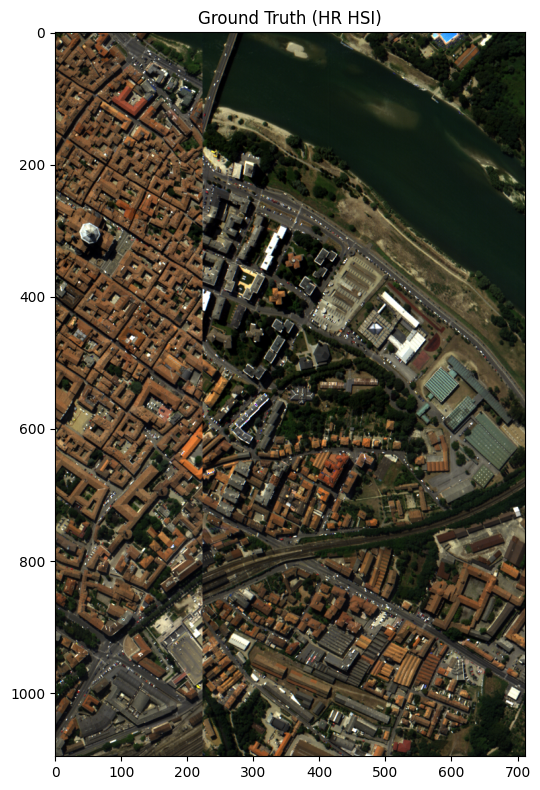

MSI shape:  (1096, 712, 3)


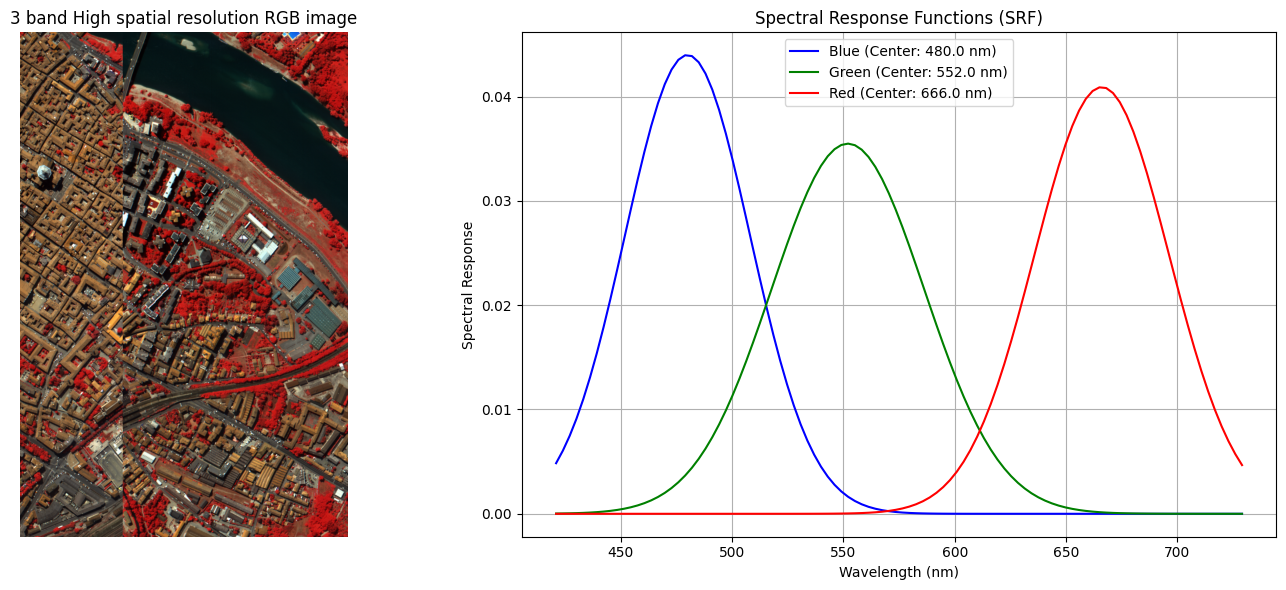

HSI shape with 8x Downsample:  (137, 89, 50)


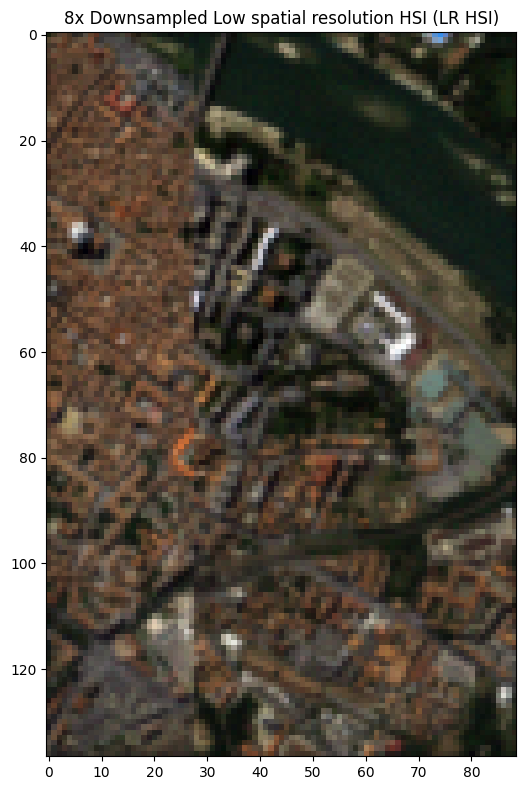

In [14]:
pavia_center = sio.loadmat(mat_file_path)
pavia_center_image = pavia_center['pavia']
pavia_center_image = pavia_center_image[:, :712, :]

# Select 50 uniformly spaced bands
selected_band_idxs = np.linspace(0, 101, 50, dtype=int)

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(pavia_center_image)
# Downsampling spectrally from 102 to 50 bands to make the training as close as possible to inference
I_REF = I_REF[:, :, selected_band_idxs]
print("Ground truth image shape: ", I_REF.shape)
visualize_hsi_single(I_REF, (25,17,7), "Ground Truth (HR HSI)")

# High Resolution MSI with 3 bands
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=pavia_center_image, SNR=40, num_bands=3, fwhm_factor=4.2)
print("MSI shape: ", I_MS_3.shape)
plot_multispectral_with_srf(I_MS_3, (2,1,0), "3 band High spatial resolution RGB image", srf_3, auto_wavs_3, band_specs_3)

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(pavia_center_image, gaus_psf, 8, 30)
# Downsampling spectrally from 102 to 50 bands to make the training as close as possible to inference
I_HS_8_gaus = I_HS_8_gaus[:, :, selected_band_idxs]
print("HSI shape with 8x Downsample: ", I_HS_8_gaus.shape)
visualize_hsi_single(I_HS_8_gaus, (25,17,7), "8x Downsampled Low spatial resolution HSI (LR HSI)")

UH Hyperspectral image 1 inference shape:  (64, 64, 50)
UH Hyperspectral image 2 inference shape:  (64, 64, 50)


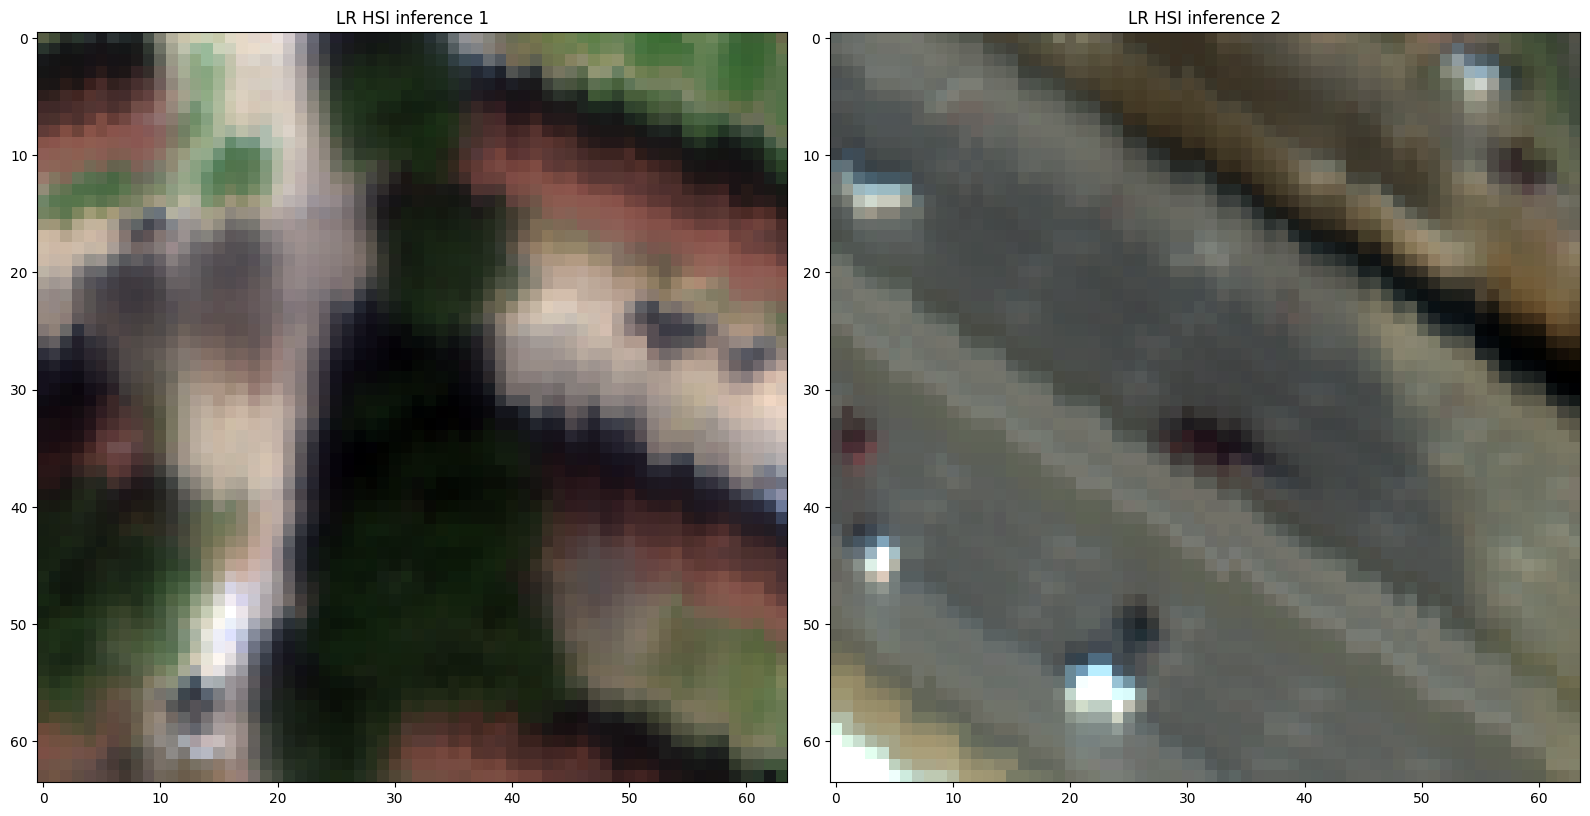

In [15]:
LR_HSI_test_1 = hsi_1_test
print("UH Hyperspectral image 1 inference shape: ", LR_HSI_test_1.shape)

LR_HSI_test_2 = hsi_2_test
print("UH Hyperspectral image 2 inference shape: ", LR_HSI_test_2.shape)

visualize_hsi(LR_HSI_test_1, LR_HSI_test_2, (20,13,8), "LR HSI inference 1", "LR HSI inference 2")

UH RGB image 1 inference shape:  (512, 512, 3)
UH RGB image 2 inference shape:  (512, 512, 3)


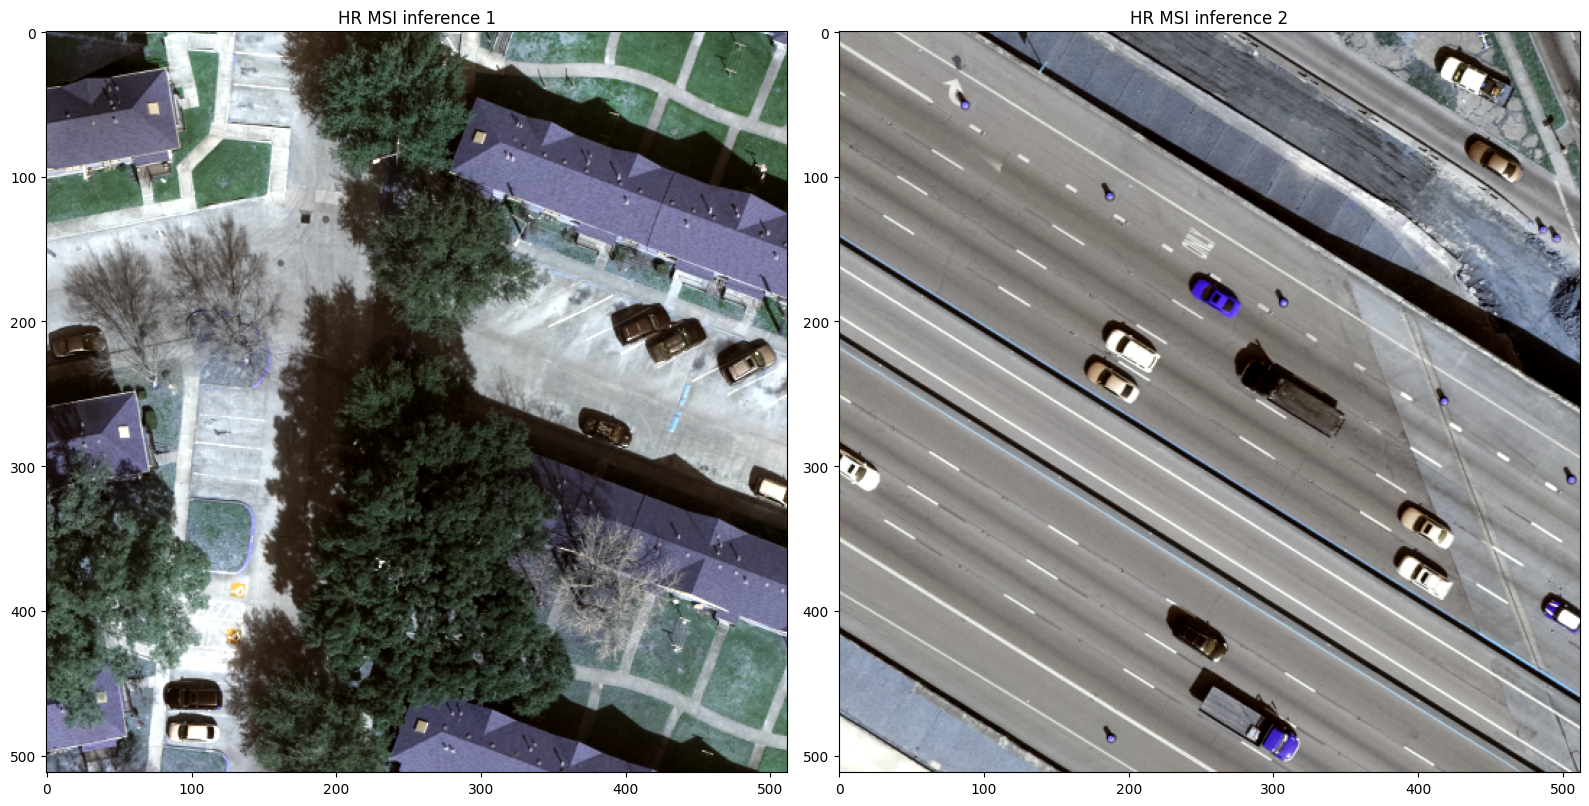

In [16]:
HR_MSI_test_1 = RGB_1_test
print("UH RGB image 1 inference shape: ", HR_MSI_test_1.shape)

HR_MSI_test_2 = RGB_2_test
print("UH RGB image 2 inference shape: ", HR_MSI_test_2.shape)

visualize_hsi(HR_MSI_test_1, HR_MSI_test_2, (0,1,2), "HR MSI inference 1", "HR MSI inference 2")

FusFormer: A Transformer-based Fusion Approach for Hyperspectral Image Super-resolution implementation from their GitHub

In [17]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors 

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [18]:
# model.py

# ----------------------- Initialization ---------------------- #
def init_weights(*modules):
    """
    Optional utility function if you want to initialize certain layers 
    (Conv, Linear, etc.) with Kaiming normal or some other scheme.
    """
    for module in modules:
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)


# ----------------------- MainNet ---------------------- #
class MainNet(nn.Module):
    """
    A parameterized version of the original MainNet, removing hard-coded 
    channel sizes and scale factors.

    Args:
      in_hsi_channels (int): Number of channels in the low-resolution HSI.
      in_msi_channels (int): Number of channels in the MSI.
      scale_factor    (int or float or None): If you specify a numeric value, 
                                             we will upsample HSI by this 
                                             factor using F.interpolate(..., scale_factor).
                                             If None, we will infer the size 
                                             from MSI (i.e. upsample to MSI's H,W).
      num_feature     (int): Latent dimension used in the Transformer (and refine conv).
      depth_e (int): Depth of encoder transformer.
      depth_d (int): Depth of decoder transformer.
      heads (int): Number of attention heads.
      dim_head (int): Dimension per attention head.
      mlp_dim (int): Hidden dimension of the feedforward layers in transformer.
      dropout (float): Dropout rate for the transformer feedforward and attention.
    """
    def __init__(
        self,
        in_hsi_channels=31,
        in_msi_channels=3,
        scale_factor=4,
        num_feature=48,
        depth_e=2,
        depth_d=2,
        heads=3,
        dim_head=16,
        mlp_dim=48,
        dropout=0.0
    ):
        super(MainNet, self).__init__()
        self.in_hsi_channels = in_hsi_channels
        self.in_msi_channels = in_msi_channels
        self.scale_factor    = scale_factor  # Could be an int, float, or None.
        self.num_feature     = num_feature

        # ---------------- Transformer Encoder / Decoder ---------------- #
        self.T_E = Transformer_E(
            dim=num_feature,
            depth=depth_e,
            heads=heads,
            dim_head=dim_head,
            mlp_dim=mlp_dim,
            dropout=dropout
        )
        self.T_D = Transformer_D(
            dim=num_feature,
            depth=depth_d,
            heads=heads,
            dim_head=dim_head,
            mlp_dim=mlp_dim,
            dropout=dropout
        )

        # ---------------- Embedding Layer ---------------- #
        # We embed (HSI + MSI) channels => num_feature
        self.Embedding = nn.Sequential(
            nn.Linear(in_hsi_channels + in_msi_channels, num_feature),
        )

        # ---------------- Refine Layer ---------------- #
        # Final 2D conv stack that produces the desired HSI channels
        self.refine = nn.Sequential(
            nn.Conv2d(num_feature, num_feature, 3, 1, 1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feature, in_hsi_channels, 3, 1, 1)
        )

    def forward(self, HSI, MSI):
        """
        Args:
          HSI: shape [B, in_hsi_channels, H_lr,  W_lr ]
          MSI: shape [B, in_msi_channels, H_hr,  W_hr ]

          - If self.scale_factor is a number, we use it directly.
          - If self.scale_factor is None, we upsample to (H_hr, W_hr).

        Returns:
          output: [B, in_hsi_channels, H_hr, W_hr]
          UP_LRHSI: [B, in_hsi_channels, H_hr, W_hr] (the upsampled LR-HSI)
          Highpass: [B, in_hsi_channels, H_hr, W_hr] (the learned correction)
        """
        B, C_lr, H_lr, W_lr = HSI.shape
        B2, C_msi, H_hr, W_hr = MSI.shape

        # ---------------- Upsample LR-HSI ---------------- #
        if self.scale_factor is not None:
            # Use the numeric scale_factor
            UP_LRHSI = F.interpolate(HSI, scale_factor=self.scale_factor, mode='bicubic')
        else:
            # Infer the final size from MSI shape
            UP_LRHSI = F.interpolate(HSI, size=(H_hr, W_hr), mode='bicubic')

        # clamp in [0,1]
        UP_LRHSI = UP_LRHSI.clamp_(0, 1)

        # ---------------- Combine Channels (UP_LRHSI + MSI) ---------------- #
        # We'll do cat along channel dimension:
        #  shape of UP_LRHSI: [B, in_hsi_channels, H_hr, W_hr]
        #  shape of MSI:      [B, in_msi_channels, H_hr, W_hr]
        Data = torch.cat((UP_LRHSI, MSI), dim=1)  # => [B, in_hsi_channels+in_msi_channels, H_hr, W_hr]

        # Flatten spatial dims => (B, H_hr*W_hr, channels)
        H_new = Data.size(2)
        W_new = Data.size(3)
        E = rearrange(Data, 'b c h w -> b (h w) c')

        # ---------------- Embedding + Transformers ---------------- #
        E = self.Embedding(E)   # => [B, H_new*W_new, num_feature]

        # Encoder / Decoder
        Code = self.T_E(E)      # => [B, H_new*W_new, num_feature]
        Highpass = self.T_D(Code)

        # Unflatten => [B, num_feature, H_new, W_new]
        Highpass = rearrange(Highpass, 'b (h w) c -> b c h w', h=H_new)

        # ---------------- Refine ---------------- #
        Highpass = self.refine(Highpass)  # => [B, in_hsi_channels, H_new, W_new]

        # output = upsampled LR_HSI + correction
        output = Highpass + UP_LRHSI
        output = output.clamp_(0, 1)

        return output, UP_LRHSI, Highpass


# ----------------- Residual, PreNorm, etc. ----------------- #
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = (
            nn.Sequential(
                nn.Linear(inner_dim, dim),
                nn.Dropout(dropout)
            )
            if project_out else nn.Identity()
        )

    def forward(self, x, mask=None):
        """
        x: [B, N, dim],  N = H*W if flattened
        """
        b, n, _, h = *x.shape, self.heads

        # separate Q, K, V
        qkv = self.to_qkv(x).chunk(3, dim=-1)  # each => [B, N, inner_dim]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        # scaled dot product
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        mask_value = -torch.finfo(dots.dtype).max

        if mask is not None:
            # If a mask is provided, apply it
            dots.masked_fill_(~mask, mask_value)

        attn = dots.softmax(dim=-1)  # => [B, h, N, N]

        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


# ----------------- Transformer_E and Transformer_D ----------------- #
class Transformer_E(nn.Module):
    """
    'Encoder' style transformer. If you do not want to use positional embeddings,
    they can be removed or replaced with learned/2D positional embeddings.
    """
    def __init__(self, dim, depth=2, heads=3, dim_head=16, mlp_dim=48, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)))
            ]))

    def forward(self, x, mask=None):
        """
        x: [B, N, dim]
        """
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x


class Transformer_D(nn.Module):
    """
    'Decoder' style transformer with a double attention block + feedforward each step.
    """
    def __init__(self, dim, depth=2, heads=3, dim_head=16, mlp_dim=48, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout))),
                Residual(PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)))
            ]))

    def forward(self, x, mask=None):
        """
        x: [B, N, dim]
        """
        for attn1, attn2, ff in self.layers:
            x = attn1(x, mask=mask)
            x = attn2(x, mask=mask)
            x = ff(x)
        return x

In [19]:
def create_positions(full_size, patch_size, stride):
    """
    Generate a list of 'start' positions along one dimension (height or width)
    such that we cover [0 ... full_size-1] completely.

    - If (patch_size == stride), you get non-overlapping patches
      except possibly the last patch, which might overlap less if the
      image size is not a multiple of stride.
    - If (patch_size > stride), patches will overlap.
    - If (patch_size < stride), you might skip some columns/rows (not recommended).
    
    Returns a list of integer 'start' positions.
    """
    positions = []
    pos = 0
    while True:
        # If adding patch_size goes beyond the boundary, clamp so the patch ends at full_size
        if pos + patch_size > full_size:
            # Shift 'pos' so that patch_size fits exactly to the end
            pos = max(full_size - patch_size, 0)
            positions.append(pos)
            break
        
        positions.append(pos)
        pos += stride

        # If we already reached or exceeded the end, break
        if pos >= full_size:
            break
    
    # Ensure positions are strictly increasing and unique
    # (the logic above should handle it, but just in case)
    positions = sorted(set(positions))
    return positions

In [20]:
def extract_3d_patches_dynamic(image_3d, patch_h, patch_w, stride_h, stride_w):
    """
    image_3d: [C, H, W] (3D tensor)
    patch_h, patch_w: desired patch height/width
    stride_h, stride_w: stride between consecutive patches in H/W
      (If stride < patch, you get overlap.
       If stride == patch, you get minimal overlap, except for the last patch.)
    
    Returns:
      patches: list of [C, patch_h, patch_w] tensors
      coords:  list of (row, col) top-left indices
    """
    c, H, W = image_3d.shape
    
    row_positions = create_positions(H, patch_h, stride_h)
    col_positions = create_positions(W, patch_w, stride_w)
    
    patches = []
    coords = []
    
    for row in row_positions:
        for col in col_positions:
            # Slice out this patch
            patch = image_3d[:, row:row+patch_h, col:col+patch_w]
            patches.append(patch)
            coords.append((row, col))
    
    return patches, coords


In [21]:
# ------------------ Hyperparameters ------------------ #
SEED = 42
LR = 1e-3
EPOCHS = 1000
STEP_SIZE = 200
GAMMA = 0.1

# ------------------ Seeding and CUDNN config ------------------ #
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
cudnn.benchmark = True
cudnn.deterministic = True

def train_with_patches(GT, LRHSI, HRMSI, model, epochs=EPOCHS,
                       patch_h=128, patch_w=128, stride_h=128, stride_w=128):
    """
    Extract patches from GT, LRHSI, HRMSI, then train patch by patch.
    - GT:    shape [C_hsi, H, W]
    - LRHSI: shape [C_hsi, H_lr, W_lr]  (model will upsample inside forward)
    - HRMSI: shape [C_msi, H, W]
    """
    
    PLoss = nn.L1Loss().cuda()  # or nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
    lr_scheduler = StepLR(optimizer=optimizer, step_size=200, gamma=0.1)

    # 1) Extract patches
    GT_patches, gt_coords = extract_3d_patches_dynamic(GT, patch_h, patch_w, stride_h, stride_w)
    MSI_patches, msi_coords = extract_3d_patches_dynamic(HRMSI, patch_h, patch_w, stride_h, stride_w)

    H_lr, W_lr = LRHSI.shape[1], LRHSI.shape[2]
    H_hr, W_hr = HRMSI.shape[1], HRMSI.shape[2]
    
    ratio_h = H_hr // H_lr
    ratio_w = W_hr // W_lr
    lr_patch_h = patch_h // ratio_h
    lr_patch_w = patch_w // ratio_w
    lr_stride_h = stride_h // ratio_h
    lr_stride_w = stride_w // ratio_w

    LR_patches, lr_coords = extract_3d_patches_dynamic(LRHSI, lr_patch_h, lr_patch_w, lr_stride_h, lr_stride_w)

    # If the number of patches doesn't match exactly, you'll need to handle that carefully,
    # or ensure your images are sized so that they line up. For example:
    # len(GT_patches) == len(MSI_patches) == len(LR_patches)

    # 2) Training loop
    with tqdm(range(1, epochs+1), desc="Training") as epbar:
        for epoch in epbar:
            model.train()
            total_loss = 0.0
            
            # For each patch
            for idx in range(len(GT_patches)):
                # Make sure we have a corresponding LR patch & MSI patch
                # If your indexing is consistent, we can assume same idx
                gt_patch  = GT_patches[idx]   # [C_hsi, patch_h, patch_w]
                msi_patch = MSI_patches[idx]  # [C_msi, patch_h, patch_w]
                lr_patch  = LR_patches[idx]   # [C_hsi, patch_h/scale, patch_w/scale]

                # Add batch dimension => [1, C, H, W]
                gt_patch  = gt_patch.unsqueeze(0).cuda()
                msi_patch = msi_patch.unsqueeze(0).cuda()
                lr_patch  = lr_patch.unsqueeze(0).cuda()

                optimizer.zero_grad()

                # Forward pass
                output, up_lr, highpass = model(lr_patch, msi_patch)
                # output: [1, C_hsi, patch_h, patch_w]

                # Compute L1
                loss = PLoss(output, gt_patch)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # End of epoch, step LR scheduler
            lr_scheduler.step()
            avg_loss = total_loss / len(GT_patches)
            epbar.set_postfix({'loss': f'{avg_loss:.6f}'})

    print("Training complete (patch-based).")
    return model

In [22]:
def test_with_patches(LRHSI, HRMSI, model,
                      patch_h=128, patch_w=128,
                      stride_h=128, stride_w=128,
                      scale=None):
    """
    Patch-based inference that mimics the training approach:
    
      - If 'scale' is a numeric value (e.g. 4, 8), 
        we assume the high-res shape is (H_lr * scale, W_lr * scale).
      - If 'scale' is None, we assume the high-res shape is exactly
        (H_hr, W_hr) from the MSI.

    The code then extracts patches from HRMSI in the high-res domain,
    extracts corresponding small patches from LRHSI in the low-res domain,
    passes them through the model, and reassembles the super-res patches
    into a full high-resolution image.

    Args:
      LRHSI: [C_hsi, H_lr, W_lr]  (low-res)
      HRMSI: [C_msi, H_hr, W_hr]  (high-res MSI)
      model: a trained model whose forward(...) upscales 'LRHSI' to match 'MSI'
      patch_h, patch_w: patch sizes in the high-res domain
      stride_h, stride_w: stride for the sliding window in the high-res domain
      scale: an integer scale factor or None

    Returns:
      big_output: a [C_hsi, H_hr, W_hr] tensor (super-res result).
    """

    model.eval()

    # 1) Determine final high-res shape
    C_hsi = model.in_hsi_channels
    H_lr, W_lr = LRHSI.shape[1], LRHSI.shape[2]
    H_hr, W_hr = HRMSI.shape[1], HRMSI.shape[2]

    if scale is not None:
        # Numeric scale factor => upsampled shape is (H_lr * scale, W_lr * scale)
        H_hr_final = H_lr * scale
        W_hr_final = W_lr * scale
    else:
        # scale is None => just use MSI shape
        H_hr_final = H_hr
        W_hr_final = W_hr

    # Create the output buffer
    big_output = torch.zeros(C_hsi, H_hr_final, W_hr_final, device=LRHSI.device)
    big_count  = torch.zeros_like(big_output)  # for overlap averaging

    # 3) Extract patches in the high-res domain from HRMSI
    MSI_patches, msi_coords = extract_3d_patches_dynamic(
        HRMSI, patch_h, patch_w, stride_h, stride_w
    )

    # 4) Extract patches in the low-res domain from LRHSI
    #    We'll assume patch_h//scale, patch_w//scale if scale is numeric
    #    else we figure out the ratio from H_lr->H_hr if needed.
    if scale is not None:
        lr_patch_h = patch_h // scale
        lr_patch_w = patch_w // scale
    else:
        # If scale=None, we interpret the ratio from:
        #   ratio_h = H_hr_final / H_lr
        #   ratio_w = W_hr_final / W_lr
        # Typically an integer if data is consistent
        ratio_h = H_hr_final // H_lr
        ratio_w = W_hr_final // W_lr
        lr_patch_h = patch_h // ratio_h
        lr_patch_w = patch_w // ratio_w

    LR_patches, lr_coords = extract_3d_patches_dynamic(
        LRHSI, lr_patch_h, lr_patch_w, lr_patch_h, lr_patch_w
    )

    # 5) Inference patch by patch
    #    We'll assume len(MSI_patches) == len(LR_patches), 
    #    or user data is consistent.
    for idx in tqdm(range(len(MSI_patches)), desc="Testing (patch-based)"):
        # shapes:
        #  msi_patch: [C_msi, patch_h, patch_w]
        #  lr_patch:  [C_hsi, lr_patch_h, lr_patch_w]
        msi_patch = MSI_patches[idx]
        lr_patch  = LR_patches[idx]
        row, col = msi_coords[idx]  # top-left in the high-res domain

        # Add batch dimension
        msi_patch = msi_patch.unsqueeze(0).to(next(model.parameters()).device)
        lr_patch  = lr_patch.unsqueeze(0).to(next(model.parameters()).device)

        # Forward pass
        with torch.no_grad():
            sr_out, _, _ = model(lr_patch, msi_patch)

            # Only profile FLOPs once on the first patch
            if idx == 0:
                try:
                    flops_sample, _ = get_flops_fvcore(model, (lr_patch.detach(), msi_patch.detach()))
                    flops_total = flops_sample * len(MSI_patches)
                except Exception as e:
                    print(f"[Warning] FLOPs could not be computed: {str(e).splitlines()[0]}")
                    flops_total = -1

        sr_patch = sr_out[0]

        # Accumulate in the final buffer
        big_output[:, row:row+patch_h, col:col+patch_w] += sr_patch
        big_count[:, row:row+patch_h, col:col+patch_w]  += 1.0

    # 6) Average overlaps
    big_count = torch.where(big_count == 0, torch.ones_like(big_count), big_count)
    big_output = big_output / big_count

    return big_output, flops_total  # [C_hsi, H_hr_final, W_hr_final]

def test_inference(model, LRHSI, HRMSI):
    """
    Perform patch-based inference and print model complexity metrics.
    """
    # shape: LRHSI => [C_hsi, H_lr, W_lr], HRMSI => [C_msi, H_hr, W_hr]
    # (both are torch.Tensor)
    model.eval()
    device = next(model.parameters()).device

    # Parameter count
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
    # Calculating GPU memory and inference time
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)
    start_memory = torch.cuda.max_memory_allocated(device)
    
    with torch.no_grad():
        start_time = time.time()
        super_res_output, flops_total = test_with_patches(
            LRHSI.to(device),
            HRMSI.to(device),
            model=model,
            patch_h=128,
            patch_w=128,
            stride_h=128,
            stride_w=128,
            scale=None
        )
        end_time = time.time()

    end_memory = torch.cuda.max_memory_allocated(device)
    inference_time = end_time - start_time
    gpu_memory_used = end_memory - start_memory

    # Print metrics
    print(f"Number of parameters: {num_params}")
    print(f"FLOPs: {flops_total}")
    print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")
    print(f"Inference time: {inference_time:.4f} seconds")

    return super_res_output

In [23]:
def extract_patch_at_coordinates(image, top_y, left_x, patch_size=16):
    """
    Extract a patch of size patch_size x patch_size starting at (top_y, left_x).

    Args:
        image (np.ndarray): Image of shape (H, W, C).
        top_y (int): Y-coordinate (row) of the top-left corner of the patch.
        left_x (int): X-coordinate (column) of the top-left corner of the patch.
        patch_size (int): Size of the patch (default: 16).

    Returns:
        patch (np.ndarray): Extracted patch of shape (patch_size, patch_size, C).
    """
    # Bounds check
    if (top_y < 0 or left_x < 0 or
        top_y + patch_size > image.shape[0] or
        left_x + patch_size > image.shape[1]):
        raise ValueError("Patch goes out of image bounds.")

    return image[top_y : top_y + patch_size, left_x : left_x + patch_size, :]

Output file to save super-resolved images

In [24]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/FusFormer"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the folder
uh_fusformer_folder_path = os.path.join(normalized_target_path, 'University_of_Houston')

# Create the folder if it doesn't exist
if not os.path.exists(uh_fusformer_folder_path):
    os.makedirs(uh_fusformer_folder_path)

Functions to set up the inputs as required by FusFormer

In [25]:
def numpy_to_torch(img_np):
    """
    Convert a NumPy image array of shape (H, W, C) to a PyTorch tensor
    with shape (C, H, W), and move it to the specified device.

    Parameters
    ----------
    img_np : np.ndarray
        Input NumPy array of shape (H, W, C).
    device : str
        Target device, e.g., 'cuda' or 'cpu'. Default is 'cuda'.

    Returns
    -------
    torch.Tensor
        Tensor of shape (C, H, W) on the specified device.
    """
    img_np = np.transpose(img_np, (2, 0, 1))        # (C, H, W)
    img_tensor = torch.from_numpy(img_np).float()   # Ensure float dtype
    return img_tensor.to(device)

def torch_to_numpy(tensor):
    """
    Convert a PyTorch tensor of shape (C, H, W) to a NumPy array of shape (H, W, C).

    Parameters
    ----------
    tensor : torch.Tensor
        PyTorch tensor with shape (C, H, W).

    Returns
    -------
    np.ndarray
        NumPy array with shape (H, W, C).
    """
    tensor = tensor.cpu().detach().numpy()          # Move to CPU and convert to NumPy
    tensor = np.transpose(tensor, (1, 2, 0))        # Convert to (H, W, C)
    return tensor

Super resolving UH image 1 

In [26]:
# Converting the data to the format FusFormer code expects
I_REF_train_tensor = numpy_to_torch(I_REF)
I_HS_train_tensor = numpy_to_torch(I_HS_8_gaus)
I_MS_train_tensor = numpy_to_torch(I_MS_3)

I_HS_test_tensor = numpy_to_torch(LR_HSI_test_1)
I_MS_test_tensor = numpy_to_torch(HR_MSI_test_1)

# ------------------ Instantiate Model, Loss, Optimizer, Scheduler ------------------ #
# Adjust these as needed:
model = MainNet(
    in_hsi_channels=I_HS_8_gaus.shape[2],    # or however many HSI channels you have
    in_msi_channels=I_MS_3.shape[2],     # or your MSI channel count
    scale_factor=None,        # or None to infer from shapes
    num_feature=48,        # transformer dimension
    depth_e=2,             # number of layers in encoder
    depth_d=2,             # number of layers in decoder
    heads=3,
    dim_head=16,
    mlp_dim=48,
    dropout=0.0
).to(device)

# Start timing
start_time = time.perf_counter()

# Training the model
trained_model = train_with_patches(
    I_REF_train_tensor,        
    I_HS_train_tensor,     
    I_MS_train_tensor,     
    model, 
    epochs=1000,
    patch_h=128,
    patch_w=128,
    stride_h=128,
    stride_w=128
)

# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")

# Infering on the test data
SR_image_tensor = test_inference(trained_model, I_HS_test_tensor, I_MS_test_tensor)
SR_image_1 = torch_to_numpy(SR_image_tensor)

print("SR image shape: ", SR_image_1.shape)

print("SR image max:", SR_image_1.max())
print("SR image min:", SR_image_1.min())
print("SR image mean:", SR_image_1.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_fusformer_folder_path}/UH_topleft.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_1)

print("Saved Super Resolved HSI 1 at location specified in uh_fusformer_folder_path")

Training: 100%|██████████| 1000/1000 [6:56:37<00:00, 25.00s/it, loss=0.011160] 


Training complete (patch-based).
Training completed in  24997.92 seconds


Testing (patch-based):   0%|          | 0/16 [00:00<?, ?it/s]Unsupported operator aten::upsample_bicubic2d encountered 1 time(s)
Unsupported operator aten::mul encountered 28 time(s)
Unsupported operator aten::mul_ encountered 7 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::add encountered 11 time(s)
Unsupported operator aten::leaky_relu_ encountered 5 time(s)
Testing (patch-based): 100%|██████████| 16/16 [00:00<00:00, 16.90it/s]


Number of parameters: 120386
FLOPs: 2505641521152.0
GPU memory consumed: 6285.12 MB
Inference time: 2.2905 seconds
SR image shape:  (512, 512, 50)
SR image max: 1.0
SR image min: 0.0
SR image mean: 0.31114078
Saved Super Resolved HSI 1 at location specified in uh_fusformer_folder_path


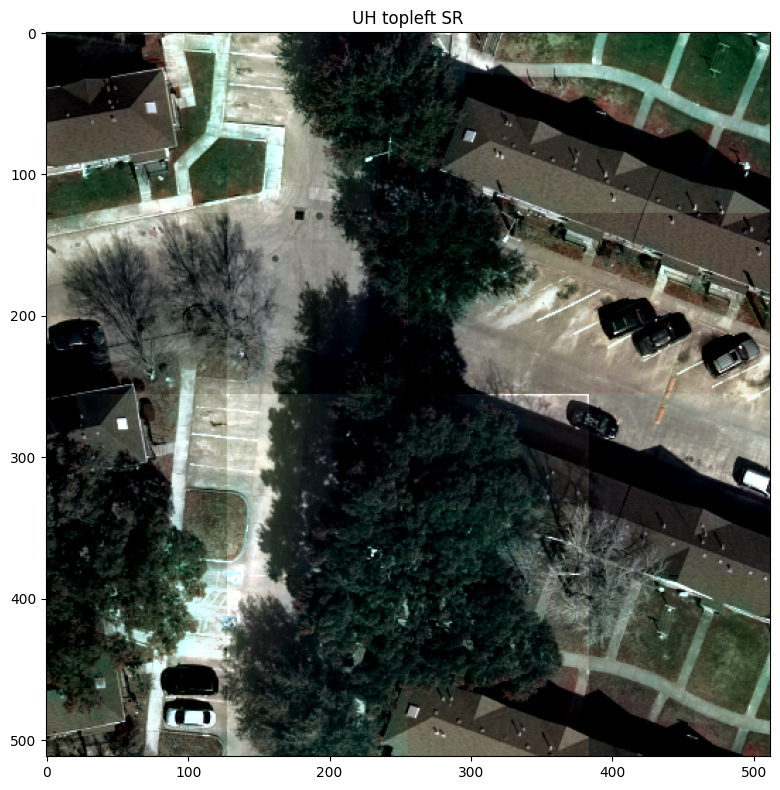

In [27]:
visualize_hsi_single(SR_image_1, (20,13,8), "UH topleft SR")

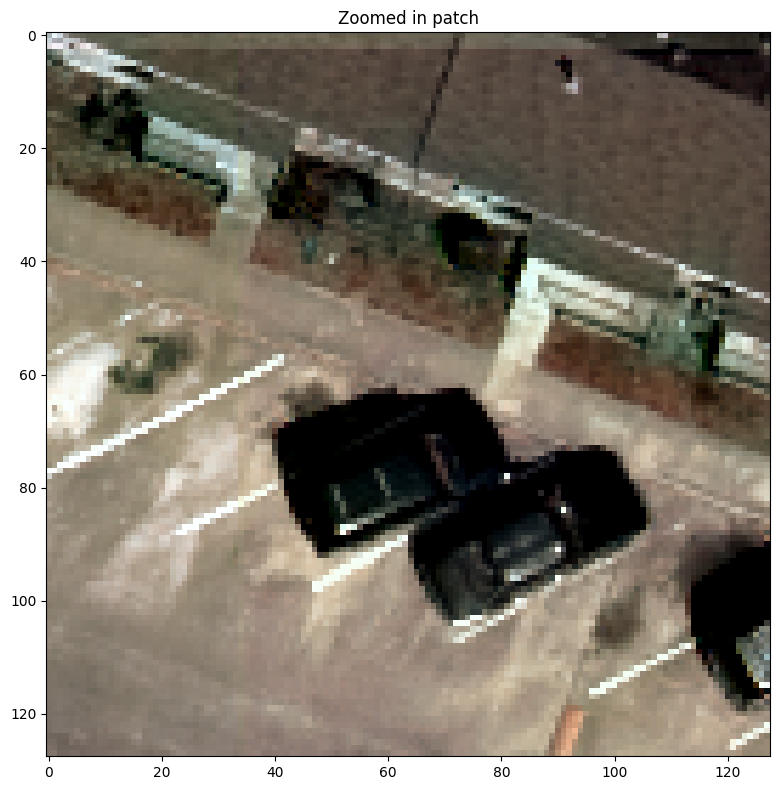

In [28]:
patch = extract_patch_at_coordinates(SR_image_1, 125, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")

Super resolving UH image 2

In [29]:
# Converting the data to the format FusFormer code expects
I_HS_test_tensor = numpy_to_torch(LR_HSI_test_2)
I_MS_test_tensor = numpy_to_torch(HR_MSI_test_2)

# Infering on the test data
SR_image_tensor = test_inference(trained_model, I_HS_test_tensor, I_MS_test_tensor)
SR_image_2 = torch_to_numpy(SR_image_tensor)

print("SR image shape: ", SR_image_2.shape)

print("SR image max:", SR_image_2.max())
print("SR image min:", SR_image_2.min())
print("SR image mean:", SR_image_2.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_fusformer_folder_path}/UH_bottomright.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_2)

print("Saved Super Resolved HSI 2 at location specified in uh_fusformer_folder_path")

Testing (patch-based):   0%|          | 0/16 [00:00<?, ?it/s]Unsupported operator aten::upsample_bicubic2d encountered 1 time(s)
Unsupported operator aten::mul encountered 28 time(s)
Unsupported operator aten::mul_ encountered 7 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::add encountered 11 time(s)
Unsupported operator aten::leaky_relu_ encountered 5 time(s)
Testing (patch-based): 100%|██████████| 16/16 [00:00<00:00, 16.96it/s]


Number of parameters: 120386
FLOPs: 2505641521152.0
GPU memory consumed: 6285.19 MB
Inference time: 0.9509 seconds
SR image shape:  (512, 512, 50)
SR image max: 1.0
SR image min: 0.0
SR image mean: 0.36893842
Saved Super Resolved HSI 2 at location specified in uh_fusformer_folder_path


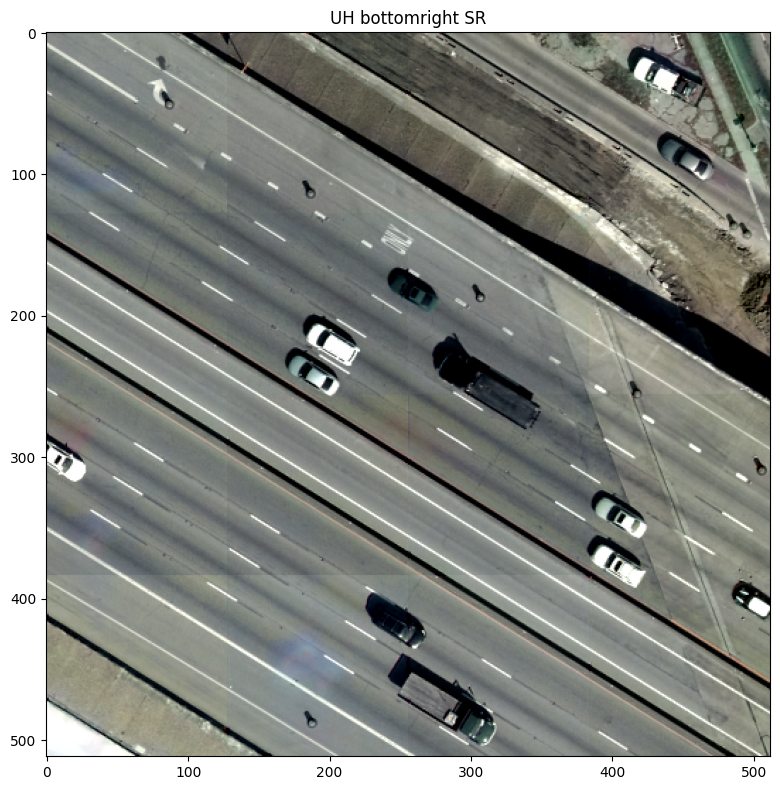

In [30]:
visualize_hsi_single(SR_image_2, (20,13,8), "UH bottomright SR")

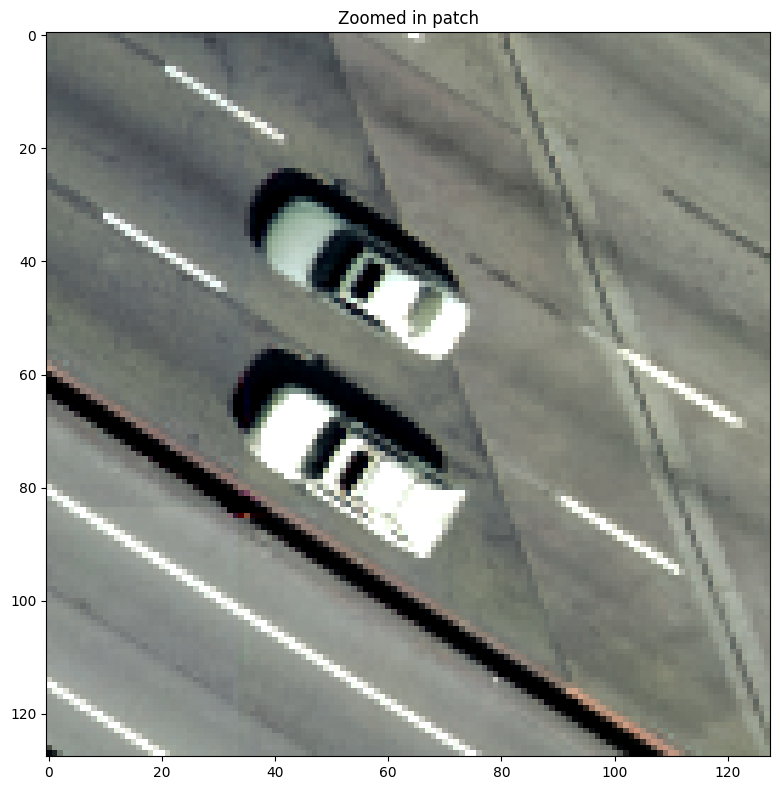

In [31]:
patch = extract_patch_at_coordinates(SR_image_2, 300, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")